In [1]:
# The Entropy of the Angenent Torus is Approximately 1.85122
# Yakov Berchenko-Kogan
# Supplementary materials

# This code computes the entropy of the Angenent doughnut.

In [2]:
import sympy as sy
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

sy.init_printing()

In [3]:
n = 2 # dimension of the doughnut.
timeStep = 1

In [4]:
# We symbolically compute the discrete Lagrangian and the
# discrete Euler-Lagrange equations.

q, v, q1, q2, qkm, qk, qkp = map(
    lambda name : sy.MatrixSymbol(name, 2, 1),
    ['q', 'v', '{q_1}', '{q_2}', '{q_{k-1}}', '{q_k}', '{q_{k+1}}']
)
deltat = sy.symbols('\Delta{}t') # time step

r, z = q # position
vr, vz = v # velocity

conformalFactor = r**(2*(n-1)) * sy.exp(-(z**2 + r**2) / 2)

# The normalization factor is set so that the entropy of the z=0 plane is 1.
normalizationFactor = (sy.integrate(
    sy.sqrt(conformalFactor.subs(z, 0)),
    (r, 0, sy.oo)
)) ** (-2)

lagrangian = normalizationFactor * conformalFactor * (vr**2 + vz**2) / 2

discreteLagrangian = deltat * lagrangian.subs({
    q: (q1+q2).as_explicit()/2,
    v: (q2 - q1).as_explicit()/deltat
})

# dEL is the discrete Euler-Lagrange operator;
# the discrete Euler-Lagrange equations are dEL = 0.
# qkm is q_{k-1}, qk is q_k, and qkp is q_{k+1}.
# See equation (4) in the article.
dEL = (
    sy.Matrix([discreteLagrangian]).jacobian(q1).subs({q1: qk, q2: qkp})
    + sy.Matrix([discreteLagrangian]).jacobian(q2).subs({q1: qkm, q2: qk})
)

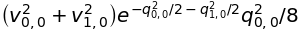

In [5]:
lagrangian

In [6]:
# This block performs an optimization, constructing Python functions
# discreteLagrangianFast and dELFast to replace the sympy expressions
# discreteLagrangian and dEL.

qkparr = sy.Matrix(sy.symarray('qkp', 2))
qkarr = sy.Matrix(sy.symarray('qk', 2))
qkmarr = sy.Matrix(sy.symarray('qkm', 2))

discreteLagrangianarr = discreteLagrangian.subs({
    q1: qkarr,
    q2: qkparr,
    deltat: timeStep
})
discreteLagrangianFast = sy.lambdify(
    (qkarr[0], qkarr[1], qkparr[0], qkparr[1]),
    discreteLagrangianarr
)

dELarr = dEL.subs({
    qkm: qkmarr,
    qk: qkarr,
    qkp: qkparr,
    deltat: timeStep
})
dELFast = sy.lambdify(
    (qkmarr[0], qkmarr[1], qkarr[0], qkarr[1], qkparr[0], qkparr[1]),
    dELarr
)

In [7]:
# dELiterator takes a pair of points (q_{k-1}, q_k), computes the
# next point q_{k+1} on the trajectory, and returns (q_k, q_{k+1}).
def dELiterator(qkm, qk) :
    equation = lambda qkp : dELFast(
        qkm[0], qkm[1],
        qk[0], qk[1],
        qkp[0], qkp[1]
    )[0]
    qkp = fsolve(equation, qk)
    return (qk, qkp)

# trajectoryFromInitialData is a generator object that generates
# a trajectory from two initial points.
def trajectoryFromInitialData(q0, q1) :
    a, b = q0, q1
    yield a
    while True:
        yield b
        a, b = dELiterator(a,b)
        
# trajectoryList returns the first N points on a trajectory with
# initial points q_0 and q_1.
def trajectoryList(q0, q1, N) :
    trajectory = trajectoryFromInitialData(np.array(q0), np.array(q1))
    return list(it.islice(trajectory, N))

# dELsystem takes a discrete trajectory qs and returns a list containing
# the output of dEL applied to each triplet of consecutive points.
# We aim to solve dELsystem = [0, ..., 0].
def dELsystem(qs) :
    equations = []
    for k in range(len(qs)) :
        equation = dELFast(
            qs[k-2][0], qs[k-2][1],
            qs[k-1][0], qs[k-1][1],
            qs[k][0], qs[k][1]
        )[0]
        equations.append(equation)
    return equations

flatten = np.concatenate
def unflatten(flatqs) :
    return np.reshape(flatqs, (len(flatqs) // 2, 2))

# dELflatsystem is a reformatting of dELsystem for use with
# SciPy's fsolve.
# Whereas dELsystem inputs and outputs a list of vectors,
# dELflatsystem inputs and outputs a list of numbers containing
# the same information.
def dELflatsystem(flatqs) :
    return flatten(dELsystem(unflatten(flatqs)))

# angenentInitialGuess gives the trajectory used as
# an initial guess for the nonlinear solver.
# N is the number of points on the trajectory.
# See the article for a more detailed discussion.
def angenentInitialGuess(N) :
    return trajectoryList([3.3, -8.5 / N], [3.3, 8.5 / N], N)

# angenentTrajectory computes the closed discrete geodesic with N points.
def angenentTrajectory(N) :
    qk0 = flatten(angenentInitialGuess(N))
    qk = fsolve(dELflatsystem, qk0)
    return unflatten(qk)

def plotTrajectory(qs) :
    xs = list(map(lambda v: v[0], qs))
    ys = list(map(lambda v: v[1], qs))
    return plt.plot(xs, ys)

def plotClosedTrajectory(qs) :
    plotTrajectory(np.concatenate([qs, [qs[0]]]))

# pathLength estimates the length of a trajectory using the formula
# given at the end of the computational methods section.
def pathLength(qs) :
    length = 0
    for k in range(1, len(qs)) :
        action = discreteLagrangianFast(
            qs[k-1][0], qs[k-1][1],
            qs[k][0], qs[k][1]
        )
        length += np.sqrt(2 * action)
    return length

# closedPathLength estimates the length of a closed path.
# The difference between closedPathLength and pathLength
# is that closedPathLength includes the distance between
# the last point and the first point of the path.
def closedPathLength(qs) :
    return pathLength(np.concatenate([qs, [qs[0]]]))

In [8]:
%time angenentTrajectory128 = angenentTrajectory(128)

CPU times: user 1.49 s, sys: 13 µs, total: 1.49 s
Wall time: 1.49 s


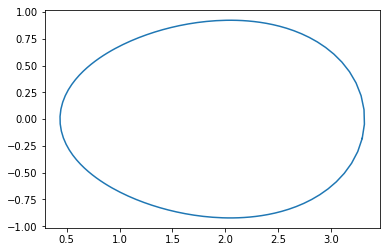

In [9]:
plotClosedTrajectory(angenentTrajectory128)

In [10]:
entropy = closedPathLength(angenentTrajectory128)

In [11]:
entropy